In [19]:
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import chi2, ksone, gamma

from radardetseval.Iface.Detection import Detection
from radardetseval.Iface.PolyLineDS import PolyLineDS
from radardetseval.configs.default_radar import DefaultRadar
from radardetseval.configs.defaut_reference import DefaultReference
from radardetseval.simulators.DetFromPolyLineSim import DetFromPolyLineSim
from radardetseval.simulators.PolyLineSim import PolyLineSim
from radardetseval.association.objective_func.nees_for_polyline import nees_value_for_vertex_ids
from radardetseval.association.nearest_point_on_line import find_nearest_point_on_segment_minimize
from radardetseval.association.nearest_point_on_line import find_nearest_point_on_polyline_minimize

from radardetseval.visualization.plot_polyline import plot_polyline, plot_polyline_range_rates
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_point import plot_point
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.ecdf import ecdf
from radardetseval.utilities.cart_state_to_polar_state import cart_state_to_polar_state

### Simulation

In [3]:
ref_pos_std = DefaultReference.pos_std
ref_vel_std = DefaultReference.vel_std

meas_cov = np.power(np.diag([DefaultRadar.range_std, DefaultRadar.azimuth_std, DefaultRadar.range_rate_std]), 2.0)
ref_cov = np.power(np.diag([ref_pos_std, ref_pos_std, ref_vel_std, ref_vel_std]), 2)

In [4]:
gt_polyline = PolyLineDS()
gt_polyline.add_point(4, -4, 4, -2)
gt_polyline.add_point(4, 4, 4, -2)
gt_polyline.add_point(8, 4, 4, -2)
gt_polyline.add_point(8, -4, 4, -2)
gt_polyline.add_point(4, -4, 4, -2)
polyline_simulator = PolyLineSim(gt_polyline)
det_simulator = DetFromPolyLineSim(gt_polyline)

In [5]:
vertex_id = 0.0
vertex_ids = gt_polyline.signals.vertex_id
gt_point = gt_polyline.interpolate_polygon(np.array([vertex_id]), vertex_ids, gt_polyline.signals)
ref_polyline = polyline_simulator.sim_with_the_same_deviation(ref_cov)
detection = det_simulator.sim_single_point_from_vertex(meas_cov, vertex_id=vertex_id)

In [6]:
gt_point

,unique_id,vertex_id,x,y,vx,vy,cov_matrix
0,0.0,0.0,4.0,-4.0,4.0,-2.0,"[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [..."


In [16]:
def plot_summary(ax, gt_polyline, ref_polyline, gt_point, detection, title_str):
    plot_sensor(ax, azimuth=np.deg2rad(75.0), max_range=15.0)
    plot_polyline(ax, gt_polyline, color='k', label = 'Ground Truth polyline')
    plot_polyline(ax, ref_polyline, color='r', label = 'Referelnce polyline')
    
    gt_polyline.signals = gt_polyline.discretize_single_polygon(gt_polyline.signals, 1.0)
    plot_polyline_range_rates(ax, gt_polyline, color='0.5', label = 'Ground Truth range rates')
    plot_point(ax, gt_point.x, gt_point.y, gt_point.vx, gt_point.vy, 
               color='g', markersize=10, linewidth=4, label = 'Point of intrest')
    
    plot_detection_scs(ax, detection.det_range, detection.det_range_rate, detection.det_azimuth, 
               color='b', markersize=10, linewidth=2, label = 'Measurement')    
    
    ax.set_title(title_str)
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    publish_reduced_labels(ax)
    ax.axis('equal')
    ax.grid()
    
    
def plot_rr(ax, gt_polyline):
    vertex_ids = gt_polyline.signals['vertex_id'].values
    vertex_ids_discirte = np.linspace(vertex_ids.min(), vertex_ids.max(), 1000)
    discirte_df = gt_polyline.interpolate_polygon(vertex_ids_discirte, vertex_ids, gt_polyline.signals)
    ref_range, ref_azimuth, ref_range_rate, _ = cart_state_to_polar_state(discirte_df['x'],
                                                                          discirte_df['y'],
                                                                          discirte_df['vx'],
                                                                          discirte_df['vy'])
    ax.plot(vertex_ids_discirte, ref_range_rate) 
    ax.set_xlabel('Vertex ID')
    ax.set_ylabel('Range Rate [m/s]')
    ax.grid()

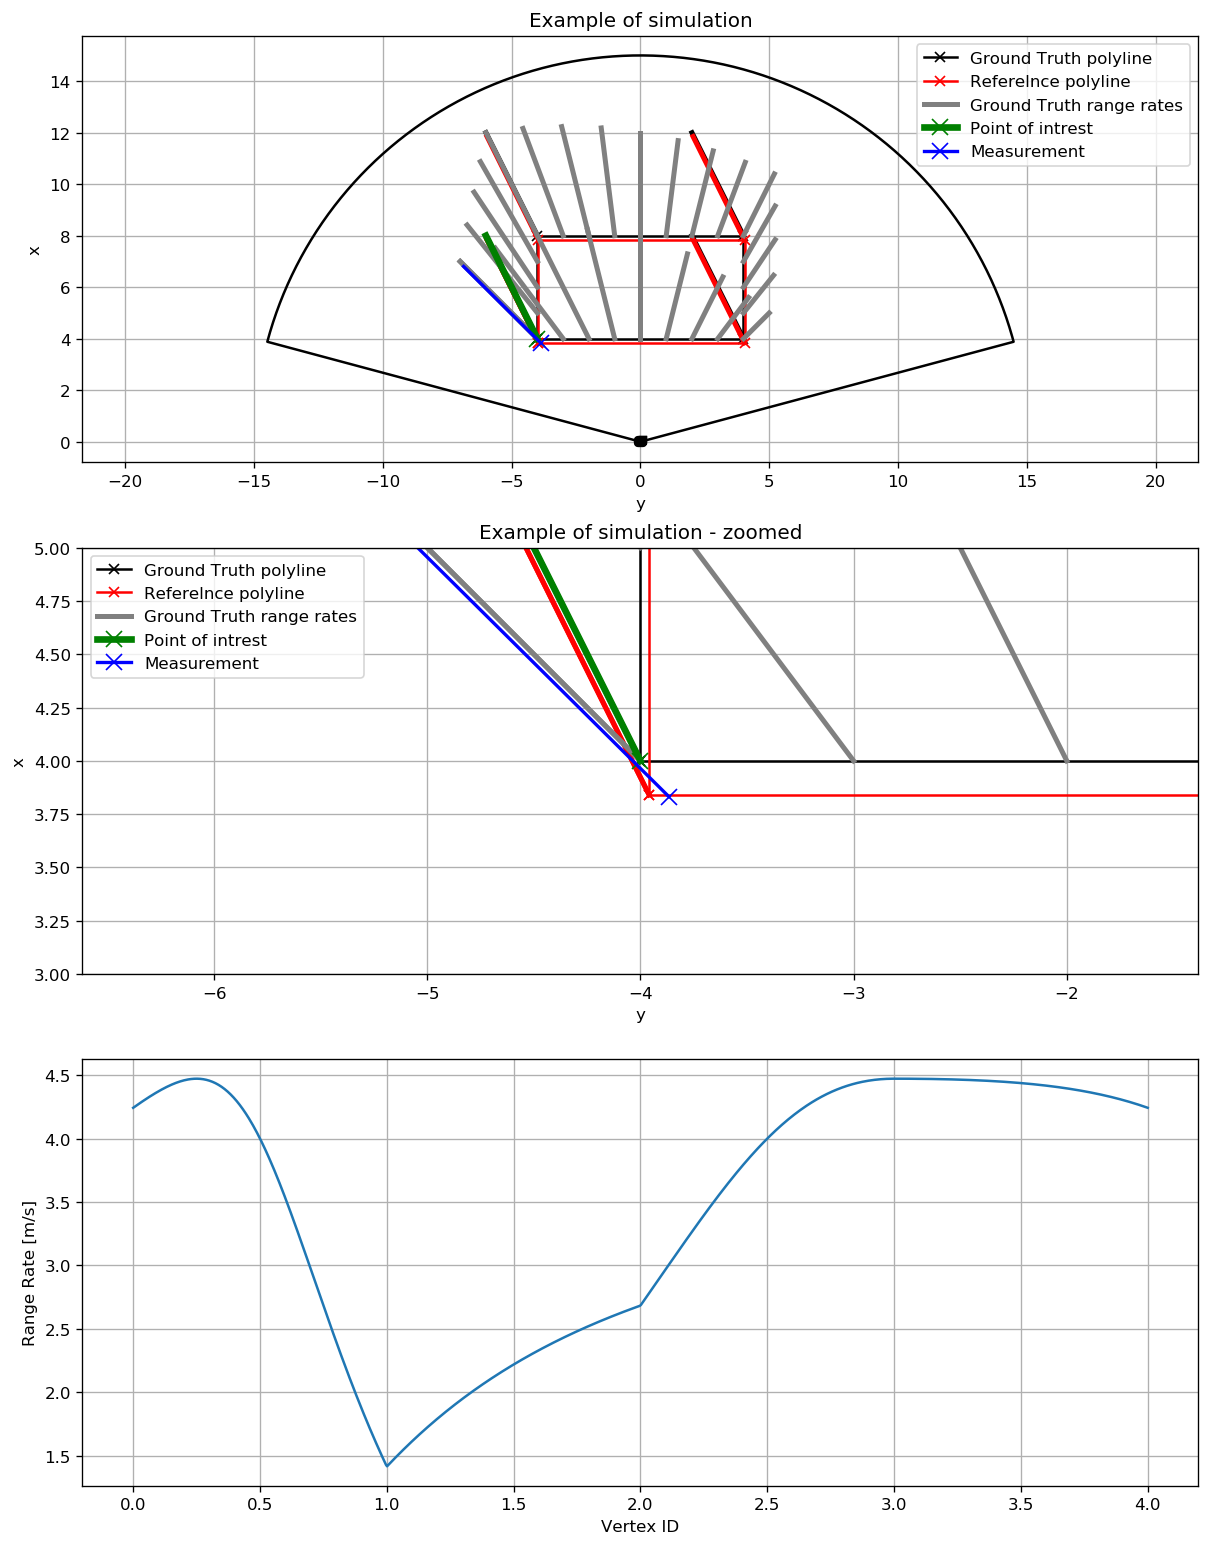

In [20]:
fig1=plt.figure(figsize=(12, 16), dpi= 120, facecolor='w', edgecolor='k')

ax1 = plt.subplot(3, 1, 1)
plot_summary(ax1, deepcopy(gt_polyline), deepcopy(ref_polyline), gt_point, detection,
             'Example of simulation')

ax2 = plt.subplot(3, 1, 2)
plot_summary(ax2, deepcopy(gt_polyline), deepcopy(ref_polyline), gt_point, detection,
             'Example of simulation - zoomed')

ax2.set_xlim([gt_point.y.values - 1,gt_point.y.values + 1])
ax2.set_ylim([gt_point.x.values - 1,gt_point.x.values + 1])

ax3 = plt.subplot(3, 1, 3)
plot_rr(ax3, gt_polyline)


In [9]:
vertex_ids = np.linspace(0, 4, 2000)
nees = nees_value_for_vertex_ids(vertex_ids, ref_polyline, detection)

In [10]:
nearest_point_seg_based = find_nearest_point_on_segment_minimize(ref_polyline, detection)
nearest_point_pl_based = find_nearest_point_on_polyline_minimize(ref_polyline, detection)

In [11]:
nearest_point_seg_based

unique_id                                                     0
vertex_id                                               3.98781
x                                                       3.88942
y                                                      -3.95933
vx                                                      4.01168
vy                                                     -1.99947
cov_matrix    [[0.010000000000000002, 0.0, 0.0, 0.0], [0.0, ...
range                                                   5.55012
azimuth                                               -0.794304
range_rate                                              4.23768
nees_value                                             0.442468
dtype: object

In [12]:
nearest_point_pl_based

unique_id                                                     0
vertex_id                                             0.0106112
x                                                       3.84066
y                                                      -3.87444
vx                                                      4.01168
vy                                                     -1.99947
cov_matrix    [[0.010000000000000002, 0.0, 0.0, 0.0], [0.0, ...
range                                                   5.45545
azimuth                                               -0.789776
range_rate                                              4.24425
nees_value                                             0.170997
dtype: object

In [13]:
def plot_closeup(ax, nearest_point, title_suffix = "", spread = 0.02):   
    min_id = max([0.0, nearest_point.vertex_id - spread])
    min_max = min([4.0, nearest_point.vertex_id + spread])
    vertex_ids_close = np.linspace(min_id, min_max, 100)
    nees_close = nees_value_for_vertex_ids(vertex_ids_close, ref_polyline, detection)
    ax.plot(vertex_ids_close, nees_close, label='nees function')
    ax.plot(nearest_point.vertex_id, nearest_point.nees_value, 'x', markersize=10, label='min value')
    ax.set_title('NEES values in function of vertex id - zoomed' + title_suffix)
    ax.set_xlabel('Vertex ID')
    ax.set_ylabel('NEES value')
    ax.legend()
    ax.grid()

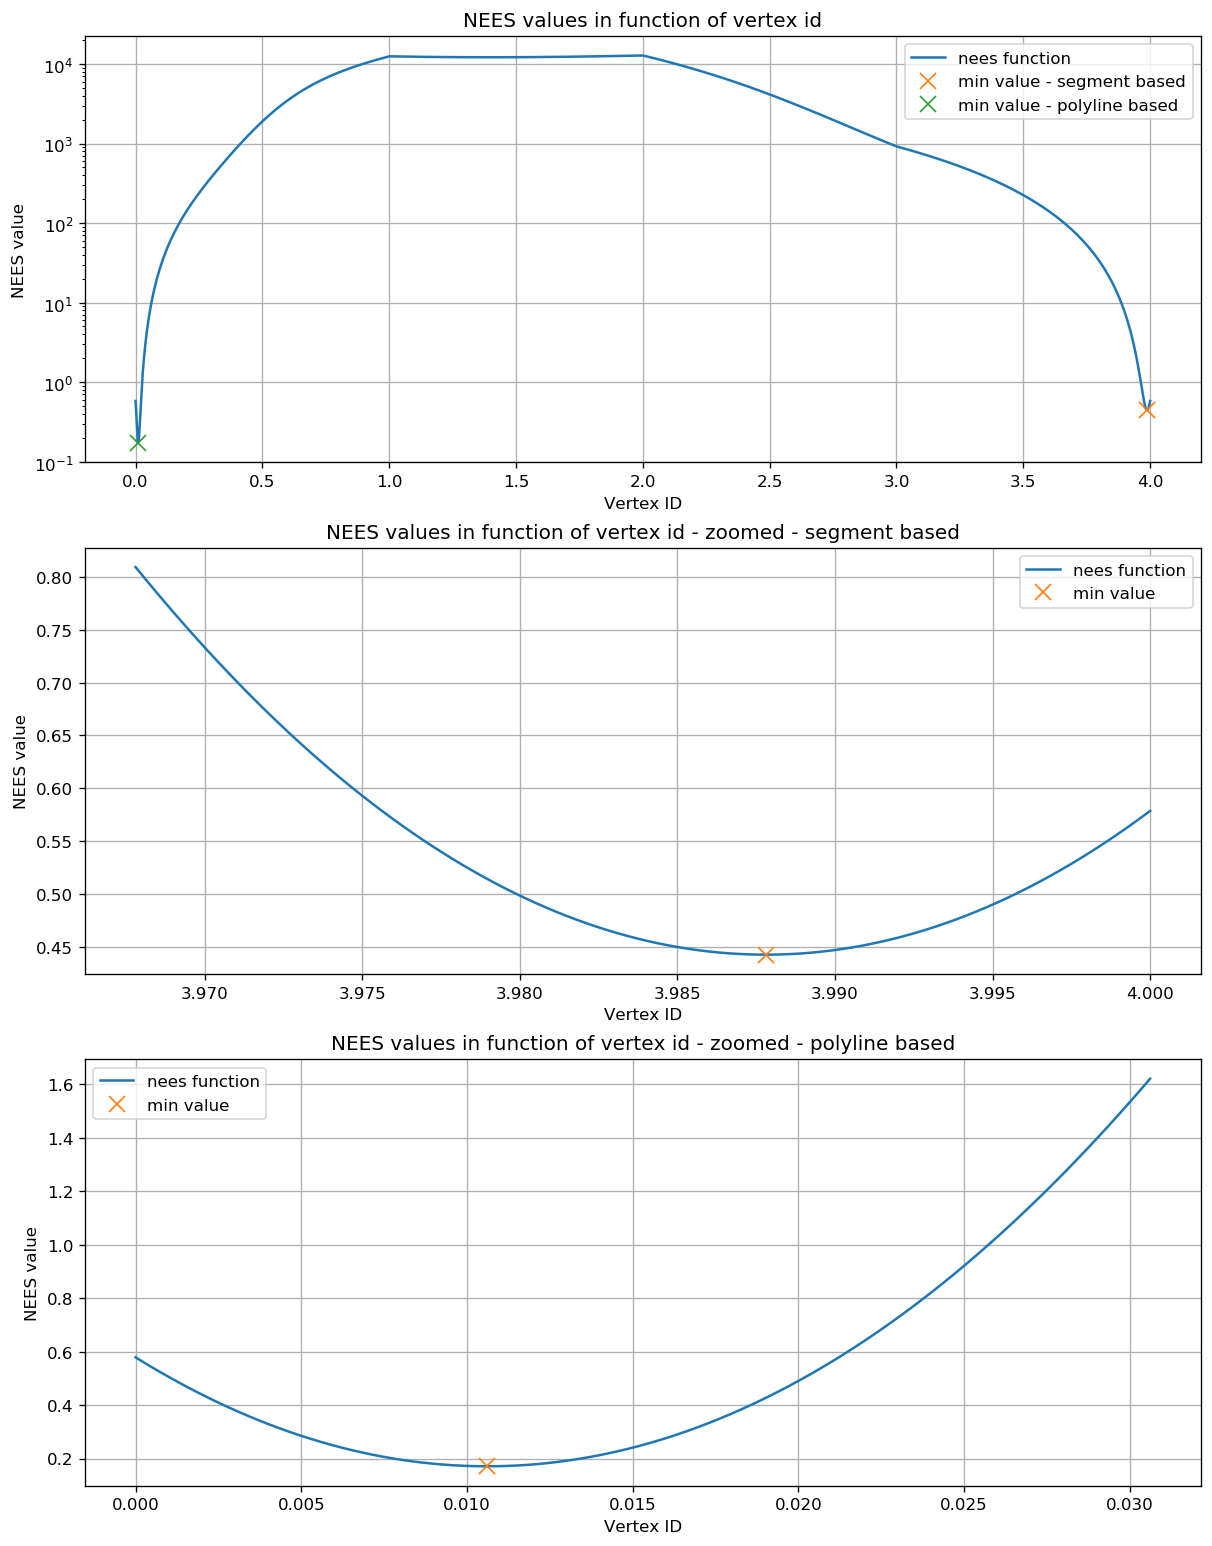

In [14]:
fig1=plt.figure(figsize=(12, 16), dpi= 120, facecolor='w', edgecolor='k')

ax1 = plt.subplot(3, 1, 1)
ax1.semilogy(vertex_ids, nees, label='nees function')
ax1.semilogy(nearest_point_seg_based.vertex_id, nearest_point_seg_based.nees_value, 'x', markersize=10, label='min value - segment based')
ax1.semilogy(nearest_point_pl_based.vertex_id, nearest_point_pl_based.nees_value, 'x', markersize=10, label='min value - polyline based')
ax1.set_title('NEES values in function of vertex id')
ax1.set_xlabel('Vertex ID')
ax1.set_ylabel('NEES value')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(3, 1, 2)
plot_closeup(ax2, nearest_point_seg_based, ' - segment based')

ax3 = plt.subplot(3, 1, 3)
plot_closeup(ax3, nearest_point_pl_based, ' - polyline based')